# Smart Grid Server Data Plotting

to visualise plots from server at: https://icelec50015.azurewebsites.net/.


In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
#%matplotlib inline

In [4]:
BASE_URL = "https://icelec50015.azurewebsites.net"
ENDPOINTS = {
    "sun": "/sun",
    "price": "/price",
    "demand": "/demand",
    "yesterday": "/yesterday",
    "deferables": "/deferables"
}

In [5]:
yesterday_url = BASE_URL + ENDPOINTS["yesterday"]
response = requests.get(yesterday_url)
yesterday_data = response.json()

yesterday_data[:3]

[{'buy_price': 39, 'demand': 2.7368238249810846, 'sell_price': 79, 'tick': 0},
 {'buy_price': 12,
  'demand': 0.007550727032645255,
  'sell_price': 25,
  'tick': 1},
 {'buy_price': 18, 'demand': 0.6351273349791459, 'sell_price': 37, 'tick': 2}]

In [6]:
df = pd.DataFrame(yesterday_data)
df.head()

,buy_price,demand,sell_price,tick
0,39,2.736824,79,0
1,12,0.007551,25,1
2,18,0.635127,37,2
3,19,0.653706,38,3
4,22,1.011864,45,4


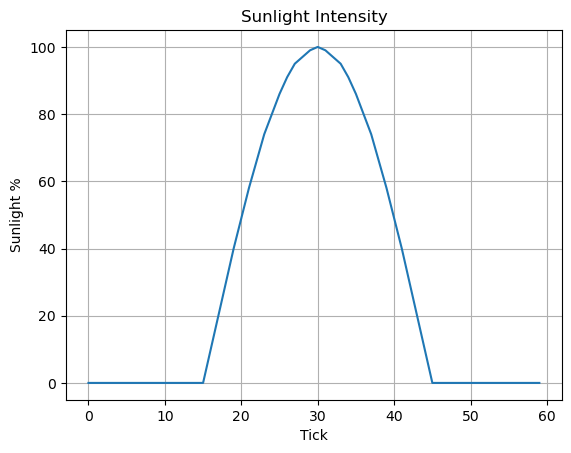

In [7]:
ticks = df['tick'].tolist()
sun_values = []
for t in ticks:
    SUNRISE = 15
    DAY_LENGTH = 30
    if t < SUNRISE:
        sun = 0
    elif t < SUNRISE + DAY_LENGTH:
        sun = int(math.sin((t-SUNRISE)*math.pi/DAY_LENGTH)*100)
    else:
        sun = 0
    sun_values.append(sun)
df['sun'] = sun_values

df.plot(x='tick', y='sun', kind='line', legend=False)
plt.title('Sunlight Intensity')
plt.xlabel('Tick')
plt.ylabel('Sunlight %')
plt.grid(True)
plt.show()

#sunlight doesn't depend on ticks, so the grpah always gonna look like this:

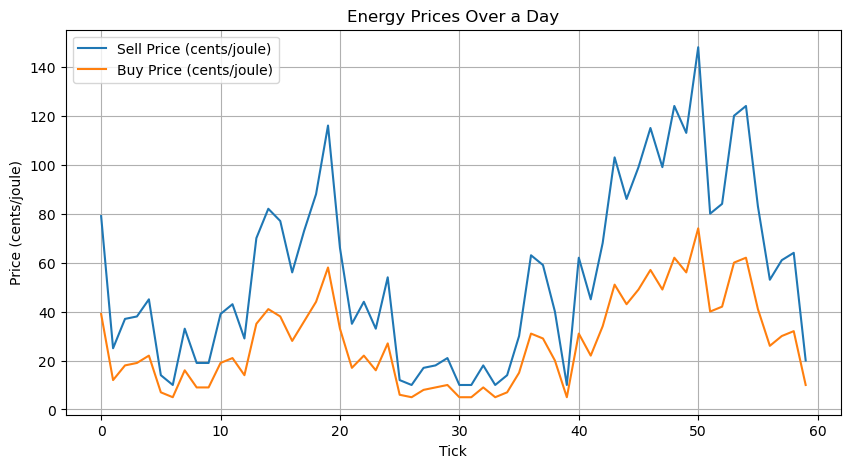

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(df['tick'], df['sell_price'], label='Sell Price (cents/joule)')
plt.plot(df['tick'], df['buy_price'], label='Buy Price (cents/joule)')
plt.title('Energy Prices Over a Day')
plt.xlabel('Tick')
plt.ylabel('Price (cents/joule)')
plt.legend()
plt.grid(True)
plt.show()

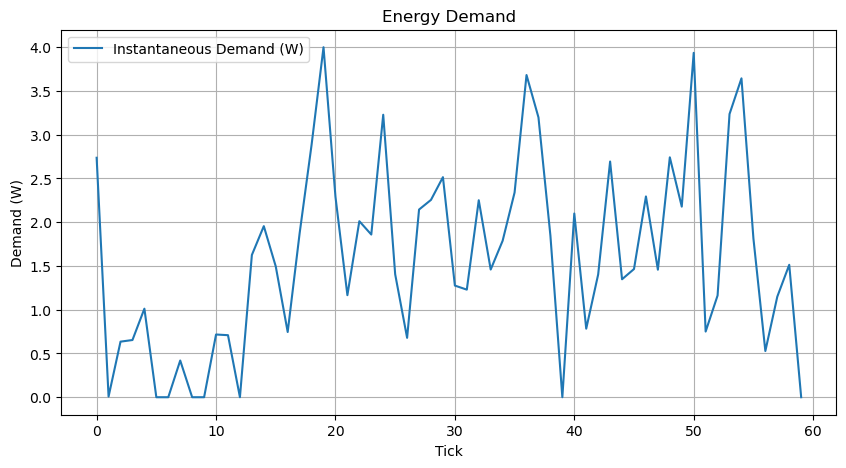

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(df['tick'], df['demand'], label='Instantaneous Demand (W)')
plt.title('Energy Demand')
plt.xlabel('Tick')
plt.ylabel('Demand (W)')
plt.legend()
plt.grid(True)
plt.show()

#energy demand:

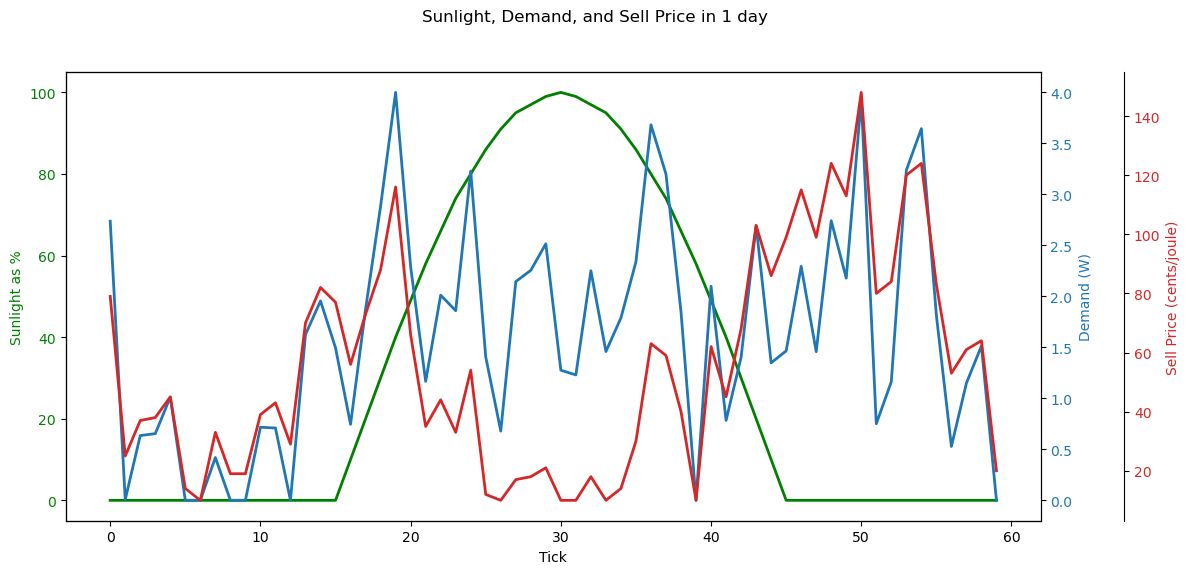

In [10]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df['tick'], df['sun'], 'green', label='Sunlight', linewidth=2)
ax1.set_ylabel('Sunlight as %', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(df['tick'], df['demand'], 'tab:blue', label='Demand', linewidth=2)
ax2.set_ylabel('Demand (W)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(df['tick'], df['sell_price'], 'tab:red', label='Sell Price', linewidth=2)
ax3.set_ylabel('Sell Price (cents/joule)', color='tab:red')
ax3.tick_params(axis='y', labelcolor='tab:red')

fig.suptitle('Sunlight, Demand, and Sell Price in 1 day')
ax1.set_xlabel('Tick')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [11]:
defer_url = BASE_URL + ENDPOINTS["deferables"]
defer_response = requests.get(defer_url)
defer_data = defer_response.json()
defer_df = pd.DataFrame(defer_data)

defer_df


,end,energy,start
0,59,50.000000,0
1,59,24.355273,40
2,48,49.890340,38


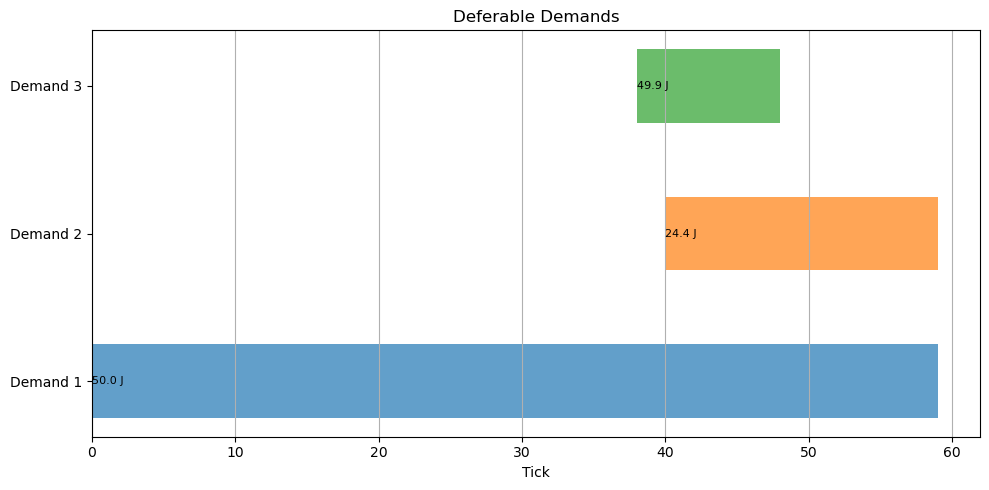

In [12]:
# Plot deferable demands as bars
plt.figure(figsize=(10, 5))
for idx, row in defer_df.iterrows():
    plt.barh(y=idx, width=row['end']-row['start'], left=row['start'], height=0.5, alpha=0.7)
    plt.text(row['start'], idx, f"{row['energy']:.1f} J", va='center', ha='left', fontsize=8)
plt.yticks(range(len(defer_df)), [f"Demand {i+1}" for i in range(len(defer_df))])
plt.xlabel('Tick')
plt.title('Deferable Demands')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [13]:
BASE_DEMAND_PROFILE = [(0,25), (10,25), (20,100), (50,100), (60,25)]

def get_base_demand(tick):
    lastp = (0,0)
    for p in BASE_DEMAND_PROFILE:
        if tick < p[0]:
            demand = int(float(tick-lastp[0])/(float(p[0]-lastp[0])) * (p[1]-lastp[1]) + lastp[1])
            break
        else:
            lastp = p
    return demand

plt.figure(figsize=(10, 5))
plt.plot(ticks, base_demand, label='Baseline Demand', linewidth=2)
plt.plot(df['tick'], df['demand'], label='Instantaneous Demand (with random variation)', linestyle='--', marker='o', markersize=4, alpha=0.7)

max_val = df['demand'].max()
max_demand = [max_val] * len(ticks)
plt.plot(ticks, max_demand, 'k--', label=f'Max Instantaneous Demand = {max_val:.2f} W')

plt.annotate(f'Max = {max_val:.2f} W',
             xy=(ticks[-1], max_val),
             xytext=(ticks[-1]-10, max_val+2),
             fontsize=10,
             color='black')

plt.title('Baseline Demand vs Instantaneous Demand')
plt.xlabel('Tick')
plt.ylabel('Demand (W)')
plt.grid(True)
plt.show()

NameError: name 'base_demand' is not defined

<Figure size 1000x500 with 0 Axes>

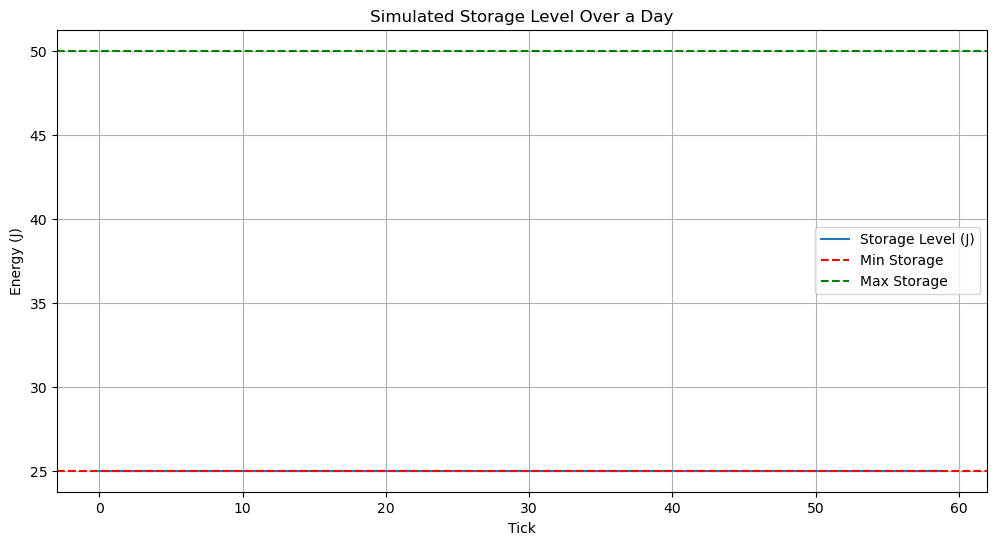

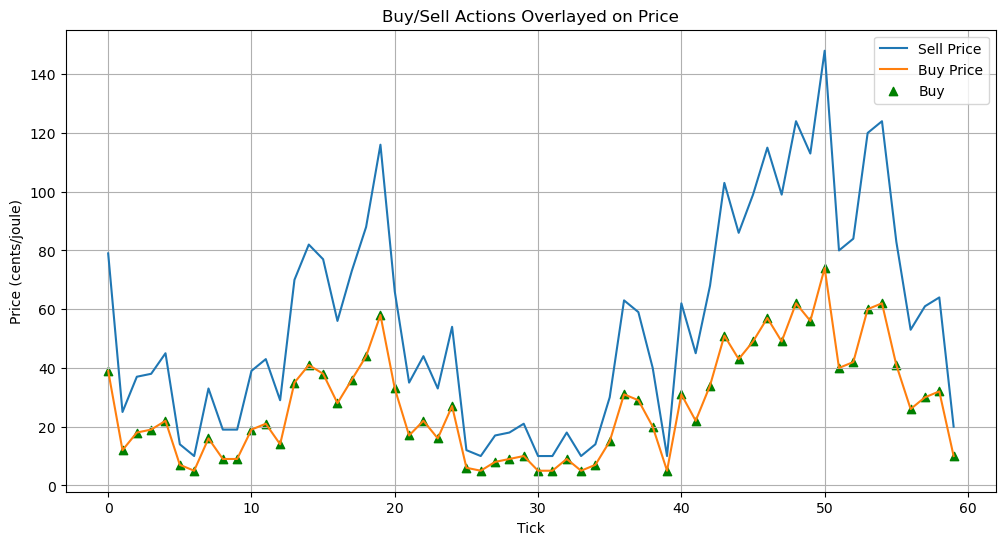

In [14]:
storage = [0]  # Start at 0 J
actions = []   # 'buy', 'sell', or 'hold'
min_storage = 25
max_storage = 50

for i in range(len(df)):
    price = df['buy_price'][i]
    sell_price = df['sell_price'][i]
    demand = df['demand'][i]
    tick = df['tick'][i]
    # For simplicity, buy if price is in the lowest 20% of the day, sell if in highest 20%
    buy_threshold = df['buy_price'].quantile(0.2)
    sell_threshold = df['sell_price'].quantile(0.8)
    current_storage = storage[-1]
    # Satisfy demand
    current_storage -= demand
    # Satisfy deferable demand if any at this tick
    defer_now = defer_df[(defer_df['start'] <= tick) & (defer_df['end'] >= tick)]
    if not defer_now.empty:
        current_storage -= defer_now['energy'].sum() / (defer_now['end'] - defer_now['start'] + 1).sum()  # spread over window
    # Enforce min storage
    if current_storage < min_storage:
        # Buy to reach min_storage
        buy_amt = min_storage - current_storage
        current_storage += buy_amt
        actions.append('buy')
    elif price <= buy_threshold and current_storage < max_storage:
        # Buy up to max
        buy_amt = max_storage - current_storage
        current_storage += buy_amt
        actions.append('buy')
    elif sell_price >= sell_threshold and current_storage > min_storage:
        # Sell down to min
        sell_amt = current_storage - min_storage
        current_storage -= sell_amt
        actions.append('sell')
    else:
        actions.append('hold')
    # Clamp storage
    current_storage = max(min_storage, min(current_storage, max_storage))
    storage.append(current_storage)

# Remove the first dummy value
storage = storage[1:]

plt.figure(figsize=(12,6))
plt.plot(df['tick'], storage, label='Storage Level (J)')
plt.axhline(min_storage, color='red', linestyle='--', label='Min Storage')
plt.axhline(max_storage, color='green', linestyle='--', label='Max Storage')
plt.xlabel('Tick')
plt.ylabel('Energy (J)')
plt.title('Simulated Storage Level Over a Day')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Overlay buy/sell actions on price
plt.figure(figsize=(12,6))
plt.plot(df['tick'], df['sell_price'], label='Sell Price')
plt.plot(df['tick'], df['buy_price'], label='Buy Price')
for i, act in enumerate(actions):
    if act == 'buy':
        plt.scatter(df['tick'][i], df['buy_price'][i], color='green', marker='^', label='Buy' if i==0 else "")
    elif act == 'sell':
        plt.scatter(df['tick'][i], df['sell_price'][i], color='red', marker='v', label='Sell' if i==0 else "")
plt.xlabel('Tick')
plt.ylabel('Price (cents/joule)')
plt.title('Buy/Sell Actions Overlayed on Price')
plt.legend()
plt.grid(True)
plt.show()

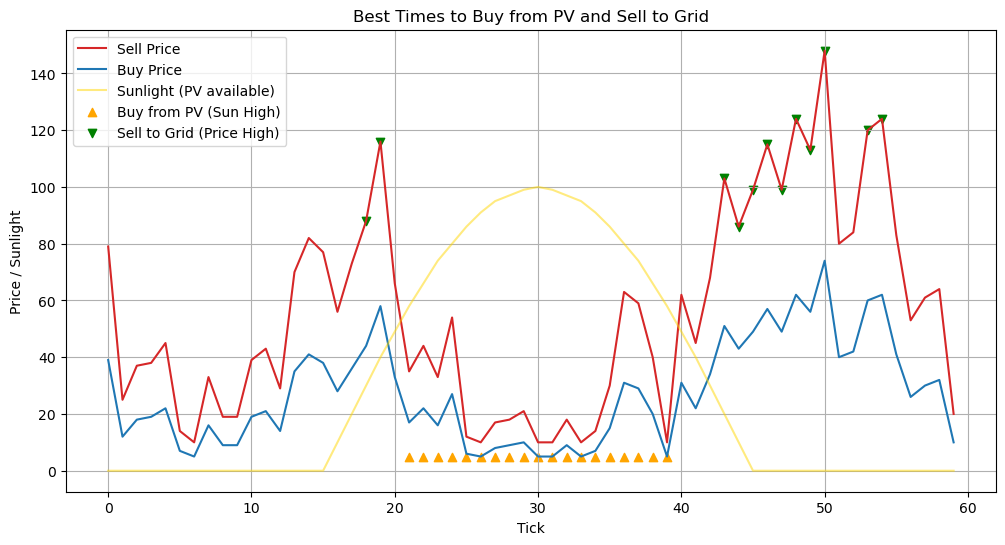

In [15]:
# Overlay best times to charge from PV and sell to grid

plt.figure(figsize=(12,6))
plt.plot(df['tick'], df['sell_price'], label='Sell Price', color='tab:red')
plt.plot(df['tick'], df['buy_price'], label='Buy Price', color='tab:blue')
plt.plot(df['tick'], df['sun'], label='Sunlight (PV available)', color='gold', alpha=0.5)

# Define thresholds
sun_threshold = 50  # Arbitrary: consider "high" sunlight above 50%
sell_threshold = df['sell_price'].quantile(0.8)  # Top 20% sell prices

# Mark best times to charge from PV (when sunlight is high)
pv_ticks = df[df['sun'] > sun_threshold]['tick']
plt.scatter(pv_ticks, [df['buy_price'].min()]*len(pv_ticks), color='orange', marker='^', label='Buy from PV (Sun High)')

# Mark best times to sell to grid (when sell price is high)
sell_ticks = df[df['sell_price'] >= sell_threshold]['tick']
plt.scatter(sell_ticks, df.loc[df['sell_price'] >= sell_threshold, 'sell_price'], color='green', marker='v', label='Sell to Grid (Price High)')

plt.xlabel('Tick')
plt.ylabel('Price / Sunlight')
plt.title('Best Times to Buy from PV and Sell to Grid')
plt.legend()
plt.grid(True)
plt.show()

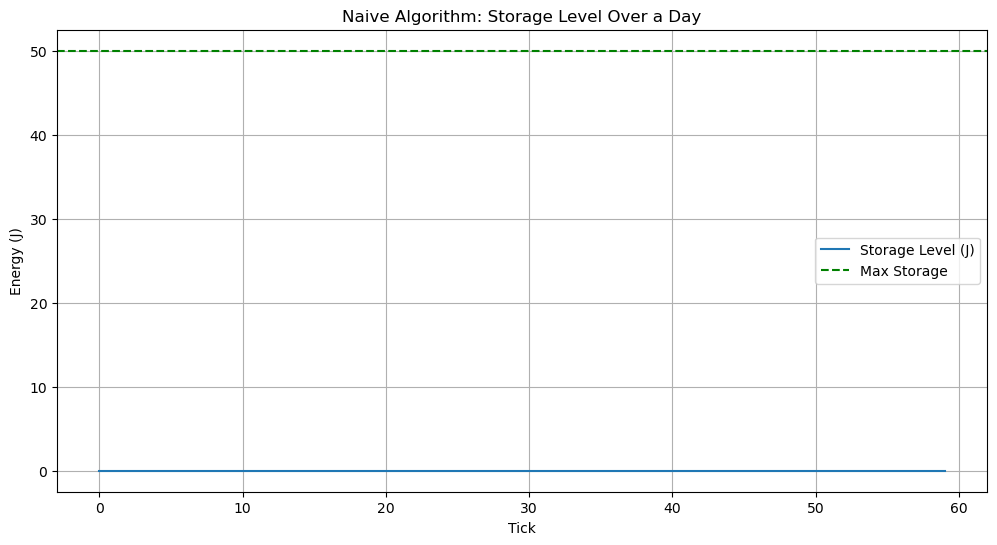

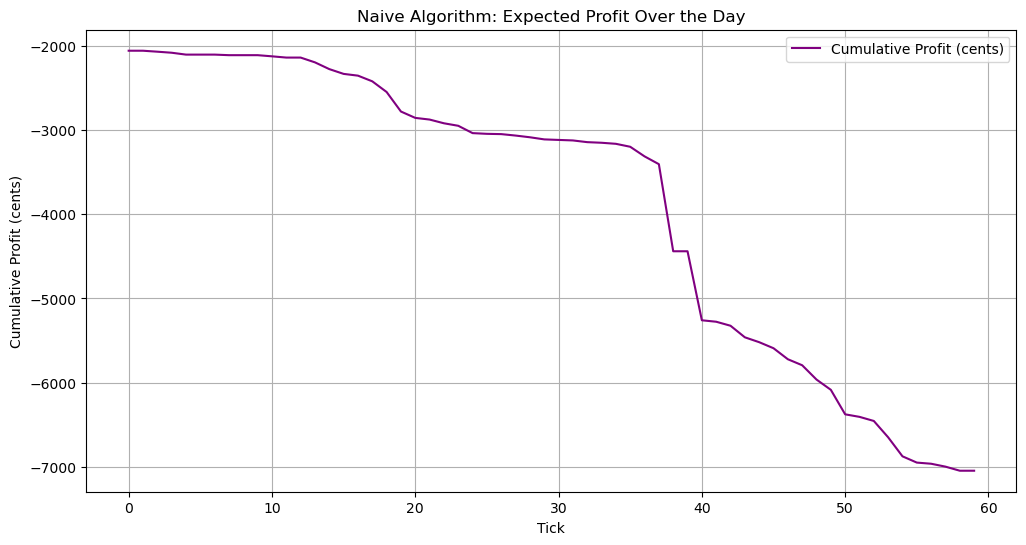

Naive algorithm expected profit (cost): -7047.33 cents


In [16]:

storage = [0]  # Start at 0 J
actions = []   # 'import', 'export', or 'hold'
profit = 0
profit_over_time = []  # Track profit at each tick

for i in range(len(df)):
    tick = df['tick'][i]
    buy_price = df['buy_price'][i]
    sell_price = df['sell_price'][i]
    demand = df['demand'][i]
    current_storage = storage[-1]

    # Satisfy instantaneous demand immediately
    if current_storage >= demand:
        current_storage -= demand
        actions.append('hold')
    else:
        import_amt = demand - current_storage
        profit -= import_amt * buy_price
        current_storage = 0
        actions.append('import')

    # Satisfy deferable demand as soon as possible
    defer_now = defer_df[(defer_df['start'] <= tick) & (defer_df['end'] >= tick)]
    if not defer_now.empty:
        for _, row in defer_now.iterrows():
            # Deliver full deferable demand at the first available tick
            if tick == row['start']:
                if current_storage >= row['energy']:
                    current_storage -= row['energy']
                else:
                    import_amt = row['energy'] - current_storage
                    profit -= import_amt * buy_price
                    current_storage = 0

    # Export any excess energy above max_storage (not likely in naive, but for completeness)
    if current_storage > max_storage:
        export_amt = current_storage - max_storage
        profit += export_amt * sell_price
        current_storage = max_storage
        actions[-1] = 'export'

    # Clamp storage
    current_storage = max(0, min(current_storage, max_storage))
    storage.append(current_storage)
    profit_over_time.append(profit)  # Track profit at each tick

# Remove the first dummy value
storage = storage[1:]

plt.figure(figsize=(12,6))
plt.plot(df['tick'], storage, label='Storage Level (J)')
plt.axhline(max_storage, color='green', linestyle='--', label='Max Storage')
plt.xlabel('Tick')
plt.ylabel('Energy (J)')
plt.title('Naive Algorithm: Storage Level Over a Day')
plt.legend()
plt.grid(True)
plt.show()

# Plot expected profit over the course of the day
plt.figure(figsize=(12,6))
plt.plot(df['tick'], profit_over_time, label='Cumulative Profit (cents)', color='purple')
plt.xlabel('Tick')
plt.ylabel('Cumulative Profit (cents)')
plt.title('Naive Algorithm: Expected Profit Over the Day')
plt.legend()
plt.grid(True)
plt.show()

print(f"Naive algorithm expected profit (cost): {profit:.2f} cents")

In [21]:
storage = [0]  # Start at 0 J
actions = []   # 'import', 'export', or 'hold'
profit = 0
profit_over_time = []  # Track profit at each tick

# Define max storage
max_storage = 50  # Joules

for i in range(len(df)):
    tick = df['tick'][i]
    buy_price = df['buy_price'][i]
    sell_price = df['sell_price'][i]
    demand = df['demand'][i]
    current_storage = storage[-1]

    # --- Step 1: Use PV supply to charge capacitor first ---
    pv_supply = df['pv_supply'][i]  # Make sure this column exists in your df
    current_storage += pv_supply
    current_storage = min(current_storage, max_storage)  # Clamp to max storage

    # --- Step 2: Satisfy instantaneous demand from storage ---
    if current_storage >= demand:
        current_storage -= demand
        actions.append('hold')
    else:
        import_amt = demand - current_storage
        profit -= import_amt * buy_price
        current_storage = 0
        actions.append('import')

    # --- Step 3: Satisfy deferable demand as soon as possible ---
    defer_now = defer_df[(defer_df['start'] <= tick) & (defer_df['end'] >= tick)]
    if not defer_now.empty:
        for _, row in defer_now.iterrows():
            if tick == row['start']:
                energy_needed = row['energy']
                if current_storage >= energy_needed:
                    current_storage -= energy_needed
                else:
                    import_amt = energy_needed - current_storage
                    profit -= import_amt * buy_price
                    current_storage = 0

    # --- Step 4: Export any excess above max storage ---
    if current_storage > max_storage:
        export_amt = current_storage - max_storage
        profit += export_amt * sell_price
        current_storage = max_storage
        actions[-1] = 'export'

    # Clamp storage between 0 and max
    current_storage = max(0, min(current_storage, max_storage))
    storage.append(current_storage)
    profit_over_time.append(profit)  # Track profit at each tick

# Remove the first dummy value
storage = storage[1:]

# -----------------------------
# Plotting Results
# -----------------------------

plt.figure(figsize=(12,6))
plt.plot(df['tick'], storage, label='Storage Level (J)')
plt.axhline(max_storage, color='green', linestyle='--', label='Max Storage (50 J)')
plt.xlabel('Tick')
plt.ylabel('Energy (J)')
plt.title('Naive Algorithm: Storage Level Over a Day')
plt.legend()
plt.grid(True)
plt.show()

# Plot expected profit over the course of the day
plt.figure(figsize=(12,6))
plt.plot(df['tick'], profit_over_time, label='Cumulative Profit (cents)', color='purple')
plt.xlabel('Tick')
plt.ylabel('Cumulative Profit (cents)')
plt.title('Naive Algorithm: Expected Profit Over the Day')
plt.legend()
plt.grid(True)
plt.show()

print(f"Naive algorithm expected profit (cost): {profit:.2f} cents")

KeyError: 'pv_supply'

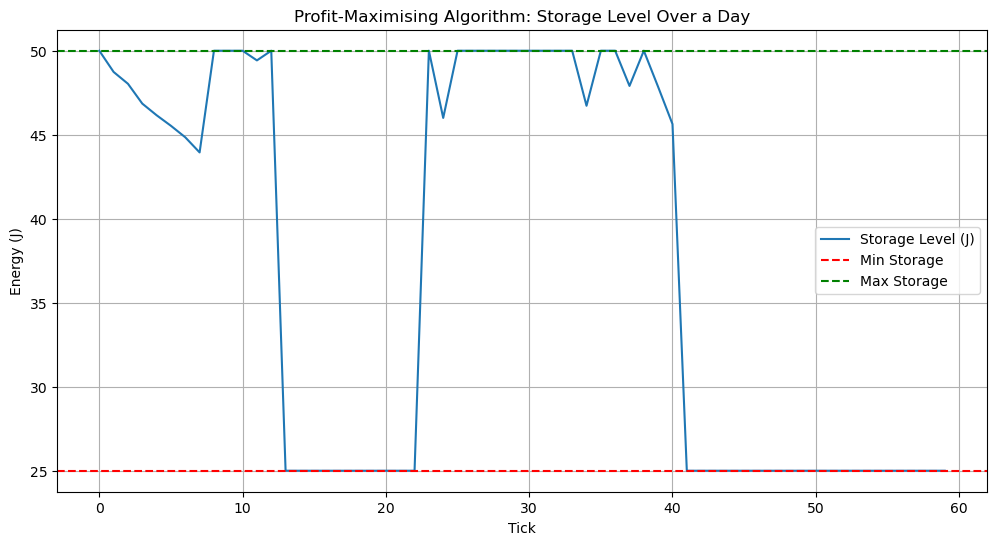

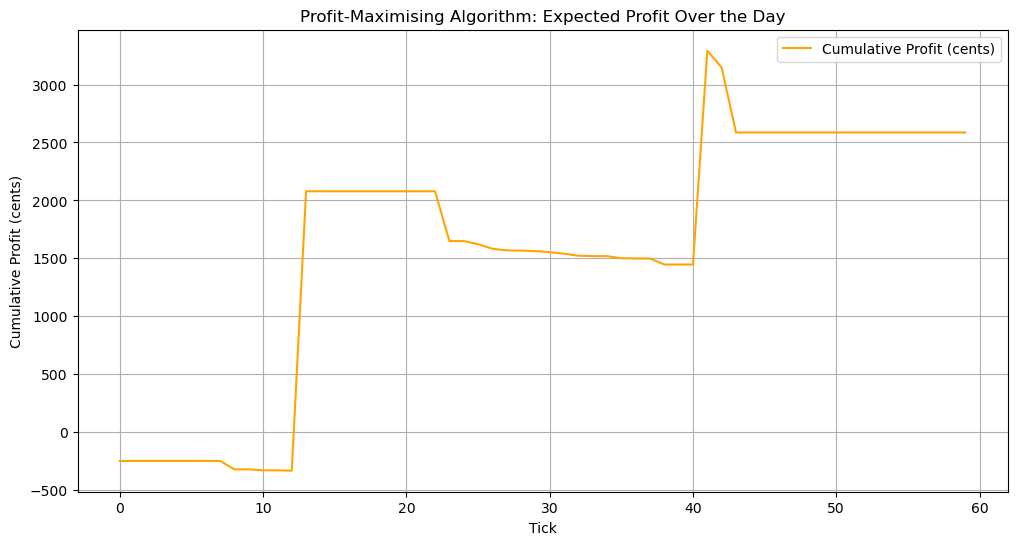

Profit-maximising algorithm expected profit (cost): 2586.36 cents


In [313]:
# Aggressive profit-maximising algorithm: keep battery as full as possible, buy when prices are low, sell only at high prices

storage = [max_storage]  # Start at full storage
actions = []
profit = 0
profit_over_time = []

buy_threshold = df['buy_price'].quantile(0.3)   # Buy when price is in the lowest 20%
sell_threshold = df['sell_price'].quantile(0.7) # Sell when price is in the highest 20%

for i in range(len(df)):
    tick = df['tick'][i]
    buy_price = df['buy_price'][i]
    sell_price = df['sell_price'][i]
    demand = df['demand'][i]
    sun = df['sun'][i]
    current_storage = storage[-1]

    # Satisfy current demand from storage if possible
    if current_storage >= demand:
        current_storage -= demand
        actions.append('hold')
    else:
        import_amt = demand - current_storage
        profit -= import_amt * buy_price
        current_storage = 0
        actions.append('import')

    # Satisfy deferable demand as soon as possible (from storage if possible)
    defer_now = defer_df[(defer_df['start'] <= tick) & (defer_df['end'] >= tick)]
    if not defer_now.empty:
        for _, row in defer_now.iterrows():
            if tick == row['start']:
                if current_storage >= row['energy']:
                    current_storage -= row['energy']
                else:
                    import_amt = row['energy'] - current_storage
                    profit -= import_amt * buy_price
                    current_storage = 0

    # Buy to keep battery as full as possible when price is low
    if buy_price <= buy_threshold and current_storage < max_storage:
        buy_amt = max_storage - current_storage
        profit -= buy_amt * buy_price
        current_storage += buy_amt
        actions.append('buy')

    # Sell only when price is high and storage is above min
    if sell_price >= sell_threshold and current_storage > min_storage:
        sell_amt = current_storage - min_storage
        profit += sell_amt * sell_price
        current_storage = min_storage
        actions.append('sell')

    # Clamp storage
    current_storage = max(min_storage, min(current_storage, max_storage))
    storage.append(current_storage)
    profit_over_time.append(profit)

# Remove the first dummy value
storage = storage[1:]

plt.figure(figsize=(12,6))
plt.plot(df['tick'], storage, label='Storage Level (J)')
plt.axhline(min_storage, color='red', linestyle='--', label='Min Storage')
plt.axhline(max_storage, color='green', linestyle='--', label='Max Storage')
plt.xlabel('Tick')
plt.ylabel('Energy (J)')
plt.title('Profit-Maximising Algorithm: Storage Level Over a Day')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(df['tick'], profit_over_time, label='Cumulative Profit (cents)', color='orange')
plt.xlabel('Tick')
plt.ylabel('Cumulative Profit (cents)')
plt.title('Profit-Maximising Algorithm: Expected Profit Over the Day')
plt.legend()
plt.grid(True)
plt.show()

print(f"Profit-maximising algorithm expected profit (cost): {profit:.2f} cents")

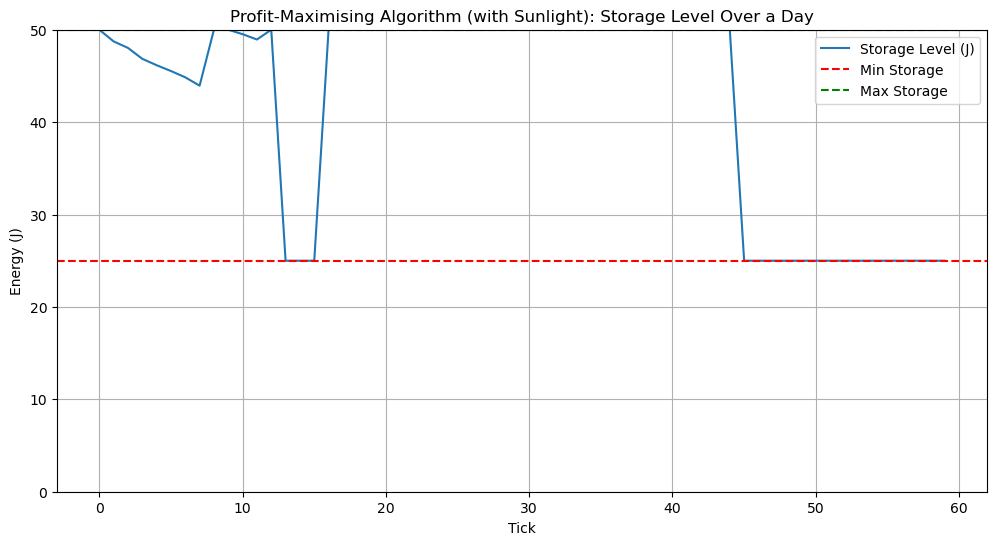

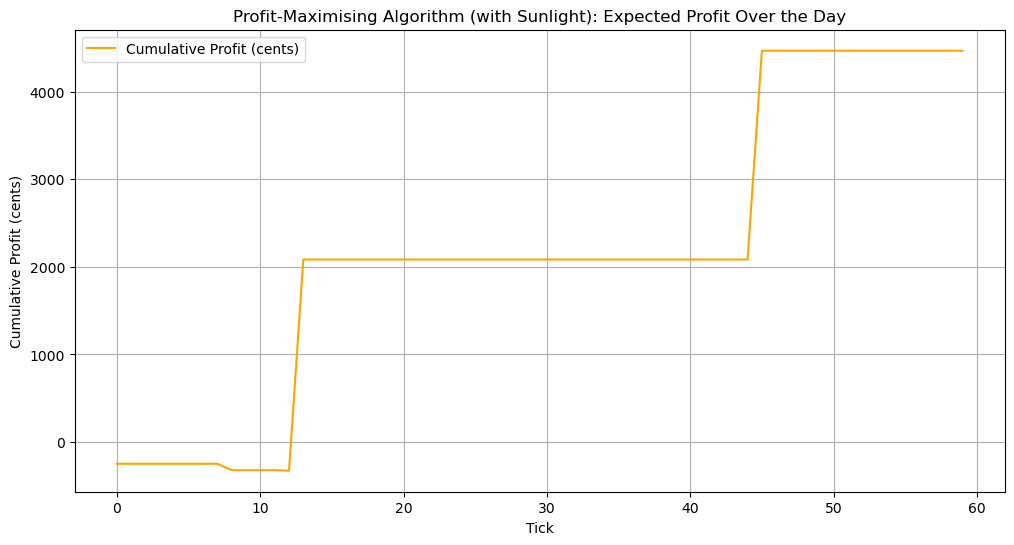

Profit-maximising algorithm (with sunlight) expected profit (cost): 4470.11 cents


In [314]:
# Aggressive profit-maximising algorithm: keep battery as full as possible, buy when prices are low, sell only at high prices, and take sunshine into account

storage = [max_storage]  # Start at full storage
actions = []
profit = 0
profit_over_time = []

buy_threshold = df['buy_price'].quantile(0.25)   # Buy when price is in the lowest 20%
sell_threshold = df['sell_price'].quantile(0.75) # Sell when price is in the highest 20%
sun_threshold = 10  # Consider "high" sunlight above 60%

for i in range(len(df)):
    tick = df['tick'][i]
    buy_price = df['buy_price'][i]
    sell_price = df['sell_price'][i]
    demand = df['demand'][i]
    sun = df['sun'][i]
    current_storage = storage[-1]

    # Satisfy current demand from storage if possible
    if current_storage >= demand:
        current_storage -= demand
        actions.append('hold')
    else:
        import_amt = demand - current_storage
        profit -= import_amt * buy_price
        current_storage = 0
        actions.append('import')

    # Satisfy deferable demand as soon as possible (from storage if possible)
    defer_now = defer_df[(defer_df['start'] <= tick) & (defer_df['end'] >= tick)]
    if not defer_now.empty:
        for _, row in defer_now.iterrows():
            if tick == row['start']:
                if current_storage >= row['energy']:
                    current_storage -= row['energy']
                else:
                    import_amt = row['energy'] - current_storage
                    profit -= import_amt * buy_price
                    current_storage = 0

    # Buy to keep battery as full as possible when price is low OR sunlight is high (charge from PV)
    if (buy_price <= buy_threshold or sun >= sun_threshold) and current_storage < max_storage:
        buy_amt = max_storage - current_storage
        # If sun is high, assume PV is available and "buy" at zero cost
        if sun >= sun_threshold:
            profit -= 0  # No cost for PV
        else:
            profit -= buy_amt * buy_price
        current_storage += buy_amt
        actions.append('buy_or_pv')

    # Sell only when price is high and storage is above min, and sunlight is not high (so we don't sell PV energy immediately)
    if sell_price >= sell_threshold and current_storage > min_storage and sun < sun_threshold:
        sell_amt = current_storage - min_storage
        profit += sell_amt * sell_price
        current_storage = min_storage
        actions.append('sell')

    # Clamp storage
    current_storage = max(min_storage, min(current_storage, max_storage))
    storage.append(current_storage)
    profit_over_time.append(profit)

# Remove the first dummy value
storage = storage[1:]

plt.figure(figsize=(12,6))
plt.plot(df['tick'], storage, label='Storage Level (J)')
plt.axhline(min_storage, color='red', linestyle='--', label='Min Storage')
plt.axhline(max_storage, color='green', linestyle='--', label='Max Storage')
plt.xlabel('Tick')
plt.ylabel('Energy (J)')
plt.ylim(0, max_storage)
plt.title('Profit-Maximising Algorithm (with Sunlight): Storage Level Over a Day')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(df['tick'], profit_over_time, label='Cumulative Profit (cents)', color='orange')
plt.xlabel('Tick')
plt.ylabel('Cumulative Profit (cents)')
plt.title('Profit-Maximising Algorithm (with Sunlight): Expected Profit Over the Day')
plt.legend()
plt.grid(True)
plt.show()

print(f"Profit-maximising algorithm (with sunlight) expected profit (cost): {profit:.2f} cents")